# Safe Drone Landing using Semantic Segmentation
**CS-GY 6953**

**TEAM MEMBERS:**

1.   **Naman Kapoor (nk2863)**
2.   **Siddhanth Lahoti (sl6981)**



## Table of Contents

- [Importing and Installing Libraries](#t1)
- [Dataset](#t2)
- [Storing, transforming and Loading Training Data](#t3)
    - [Creating Dataset to load the dataset to dataloader](#t33)
    - [Creating Transformations and loading data in mini-batches](#t34)
- [Model Initialization](#t4)
- [Training](#t5)
    - [Calculating pixel accuracy by comparing predicted and mask output](#t51)
    - [Calculating IOU](#t52)
    - [Implementing Training Step](#t53)
    - [Init loss, optimizer, epochs and executing training step](#t54)
- [Saving trained model](#t6)
- [Train Data Result Analysis](#t7)
    - [Plotting loss, IOU and accuracy curve](#t71)
- [Storing, Transforming and Loading Test dataset](#t8)
    - [Creating Dataset to load test dataset to dataloader](#t81)
- [Test Result Analysis](#t9)
    - [Calculating IOU and pixel accuracy score over entire dataset](#t91)
    - [Plotting test and predicted images](#t92)

# Importing and Installing Libraries
<a id='Importing-and-Installing-Libraries'></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable

from PIL import Image
import cv2
import albumentations as A

import time
import os
from tqdm.notebook import tqdm

!pip install -q segmentation-models-pytorch
!pip install -q torchsummary

from torchsummary import summary
import segmentation_models_pytorch as smp

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<a name="t2"></a>
# Dataset

The dataset is freely available from http://dronedataset.icg.tugraz.at

Dataset obtained from - https://www.tugraz.at/index.php?id=22387

The dataset contains 400 training and 200 test set images of size 6000 x 4000px. The dataset depicts more than 20 houses from nadir view acquired at an altitude of 5 to 30 meters above ground.

In [ ]:
#Loading the dataset and its labels
IMAGE_PATH = '/content/drive/MyDrive/DeepLearning/dataset/dataset/semantic_drone_dataset/original_images/'
MASK_PATH = '/content/drive/MyDrive/DeepLearning/dataset/dataset/semantic_drone_dataset/label_images_semantic/'

In [ ]:
#n_classes, 23 is the total number of distinct labels available
n_classes = 23 

# tree, gras, other vegetation, dirt, gravel, rocks, water, 
#paved area, pool, person, dog, car, bicycle, roof, wall, fence, 
#fence-pole, window, door, obstacle

def create_df():
    name = []
    for dirname, _, filenames in os.walk(IMAGE_PATH):
        for filename in filenames:
            name.append(filename.split('.')[0])
    
    return pd.DataFrame({'id': name}, index = np.arange(0, len(name)))

#creating dataframe to store and index images
df = create_df()
print('Number of Images: ', len(df))

Total Images:  400


In [ ]:
#Split the dataset to train, test and validation set.
X_trainval, X_test = train_test_split(df['id'].values, test_size=0.1, random_state=19)
X_train, X_val = train_test_split(X_trainval, test_size=0.15, random_state=19)

print('Train Size   : ', len(X_train))
print('Val Size     : ', len(X_val))
print('Test Size    : ', len(X_test))

Train Size   :  306
Val Size     :  54
Test Size    :  40


Image Size (4000, 6000, 3)
Mask Size (4000, 6000)


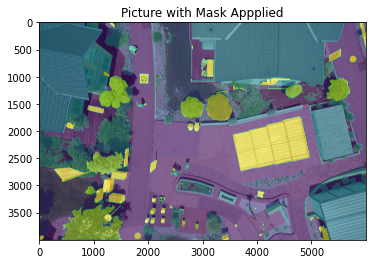

In [ ]:
#Displaying 100th sample image
img = Image.open(IMAGE_PATH + df['id'][100] + '.jpg')
mask = Image.open(MASK_PATH + df['id'][100] + '.png')
print('Image Size', np.asarray(img).shape)
print('Mask Size', np.asarray(mask).shape)


plt.imshow(img)
plt.imshow(mask, alpha=0.6)
plt.title('Picture with Mask Appplied')
plt.show()

<a name="t3"></a>
# Storing, Transforming and Loading Training Data

<a name="t31"></a>
Creating Dataset to load the dataset to dataloader

In [ ]:
#Dataset to store and fetch training dataset, after applying transformations
class DroneDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, mean, std, transform=None, patch=False):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
        self.patches = patch
        self.mean = mean
        self.std = std
        
    def __len__(self):
        return len(self.X)
    
    #Fetching an item from training dataset
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        #transform different for image and mask
        t = T.Compose([T.ToTensor(), T.Normalize(self.mean, self.std)])
        img = t(img)
        mask = torch.from_numpy(mask).long()
        
        if self.patches:
            img, mask = self.tiles(img, mask)
            
        return img, mask
    
    def tiles(self, img, mask):

        img_patches = img.unfold(1, 512, 512).unfold(2, 768, 768) 
        img_patches  = img_patches.contiguous().view(3,-1, 512, 768) 
        img_patches = img_patches.permute(1,0,2,3)
        
        mask_patches = mask.unfold(0, 512, 512).unfold(1, 768, 768)
        mask_patches = mask_patches.contiguous().view(-1, 512, 768)
        
        return img_patches, mask_patches

<a name="t32"></a>
Creating Transformations and loading data in mini-batches

In [ ]:
#Reference: https://pytorch.org/vision/stable/models.html
#All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W),
#where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using 
#mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

#Creating tranformations using Albumentations library as it is faster than torchvision.

#Albumentations is a Python library for fast and flexible image augmentations. By using image augmentations we are able to increase the size and diversity of
#our labeled training dataset.

#We are converting image size to 704x1056
t_train = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(), A.VerticalFlip(), 
                     A.GridDistortion(p=0.2), A.RandomBrightnessContrast((0,0.5),(0,0.5)),
                     A.GaussNoise()])

t_val = A.Compose([A.Resize(704, 1056, interpolation=cv2.INTER_NEAREST), A.HorizontalFlip(),
                   A.GridDistortion(p=0.2)])

#transformed datasets
train_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_train, mean, std, t_train, patch=False)
val_set = DroneDataset(IMAGE_PATH, MASK_PATH, X_val, mean, std, t_val, patch=False)

#dataloader, batch size kept as 3.
batch_size= 3 

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)          
print(t_train)

<a name="t4"></a>

# Model Initialization

In [ ]:
#We are using UNET architecture as our model, using mobilenet_v2 to encode and using it as feature extractor to build segmentation model.
#We are using imagenet pre initialized weights on ImageNet.

model = smp.Unet('mobilenet_v2', encoder_weights='imagenet', classes=23, activation=None, encoder_depth=5, decoder_channels=[256, 128, 64, 32, 16])

<a name="t5"></a>
#Training

Calculating pixel accuracy by comparing predicted and mask(labelled) output.

In [ ]:
def pixel_accuracy(output, mask):
    with torch.no_grad():
        #shape of output will be [3, 23, 704, 1056]
        output = torch.argmax(F.softmax(output, dim=1), dim=1)
        #shape after above step is [3, 704, 1056]
        correct = torch.eq(output, mask).int()
        #PyTorch torch.numel() method returns the total number of elements in the input tensor.
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy

Calculating Intersection over Union value for each labeled class over mask and predicted dataset.

In [ ]:
#Calculating Intersection over Uinon value for each class on a dataset.
def mIoU(pred_mask, mask, smooth=1e-10, n_classes=23):
    with torch.no_grad():
        pred_mask = F.softmax(pred_mask, dim=1)
        pred_mask = torch.argmax(pred_mask, dim=1)
        pred_mask = pred_mask.contiguous().view(-1)
        mask = mask.contiguous().view(-1)

        iou_per_class = []
        for cls in range(0, n_classes):
            true_class = pred_mask == cls
            true_label = mask == cls
            
            #if not exists
            if true_label.long().sum().item() == 0: 
                iou_per_class.append(np.nan)
            else:
                intersect = torch.logical_and(true_class, true_label).sum().float().item()
                union = torch.logical_or(true_class, true_label).sum().float().item()

                iou = (intersect + smooth) / (union +smooth)
                iou_per_class.append(iou)
        return np.nanmean(iou_per_class)

Implementing Training step

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, model, train_loader, val_loader, criterion, optimizer, scheduler, patch=False):
    torch.cuda.empty_cache()
    train_losses = []
    test_losses = []
    val_iou = []; val_acc = []
    train_iou = []; train_acc = []
    lrs = []
    min_loss = np.inf
    decrease = 1 ; not_improve=0

    model.to(device)
    fit_time = time.time()
    for e in range(epochs):
        since = time.time()
        running_loss = 0
        iou_score = 0
        accuracy = 0
        #training loop
        model.train()

        #tqdm is used for progress bar
        for i, data in enumerate(tqdm(train_loader)):
            #training phase
            image_tiles, mask_tiles = data

            #patch is false while training
            if patch:
                bs, n_tiles, c, h, w = image_tiles.size()

                image_tiles = image_tiles.view(-1,c, h, w)
                mask_tiles = mask_tiles.view(-1, h, w)
            
            image = image_tiles.to(device); mask = mask_tiles.to(device);
            #forward
            output = model(image)
            loss = criterion(output, mask)
            #evaluation metrics
            iou_score += mIoU(output, mask)
            accuracy += pixel_accuracy(output, mask)
            #backward
            loss.backward()
            optimizer.step() #update weight          
            optimizer.zero_grad() #reset gradient
            
            #step the learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step() 
            
            running_loss += loss.item()
            
        else:
            model.eval()
            test_loss = 0
            test_accuracy = 0
            val_iou_score = 0
            #validation loop
            with torch.no_grad():
                for i, data in enumerate(tqdm(val_loader)):
                    #reshape to 9 patches from single image, delete batch size
                    image_tiles, mask_tiles = data

                    if patch:
                        bs, n_tiles, c, h, w = image_tiles.size()

                        image_tiles = image_tiles.view(-1,c, h, w)
                        mask_tiles = mask_tiles.view(-1, h, w)
                    
                    image = image_tiles.to(device); mask = mask_tiles.to(device);
                    output = model(image)
                    #evaluation metrics
                    val_iou_score +=  mIoU(output, mask)
                    test_accuracy += pixel_accuracy(output, mask)
                    #loss, criterion is our cross entropy loss function
                    loss = criterion(output, mask)                                  
                    test_loss += loss.item()
            
            #calculatio mean for each batch
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(val_loader))

            # save model if loss is decreasing for 5 epochs
            if min_loss > (test_loss/len(val_loader)):
                print('Loss Decreasing.. {:.3f} >> {:.3f} '.format(min_loss, (test_loss/len(val_loader))))
                min_loss = (test_loss/len(val_loader))
                decrease += 1
                if decrease % 5 == 0:
                    print('saving model...')
                    torch.save(model, '/content/drive/MyDrive/DeepLearning/Unet-Mobilenet_v2_mIoU-{:.3f}.pt'.format(val_iou_score/len(val_loader)))
                    
            #stop the training if min_loss not improve for 7 epochs
            if (test_loss/len(val_loader)) > min_loss:
                not_improve += 1
                min_loss = (test_loss/len(val_loader))
                print(f'Loss Not Decrease for {not_improve} time')
                if not_improve == 7:
                    print('Loss not decrease for 7 times, Stop Training')
                    break
            
            #iou
            val_iou.append(val_iou_score/len(val_loader))
            train_iou.append(iou_score/len(train_loader))
            train_acc.append(accuracy/len(train_loader))
            val_acc.append(test_accuracy/ len(val_loader))
            print("Epoch:{}/{}..".format(e+1, epochs),
                  "Train Loss: {:.3f}..".format(running_loss/len(train_loader)),
                  "Val Loss: {:.3f}..".format(test_loss/len(val_loader)),
                  "Train mIoU:{:.3f}..".format(iou_score/len(train_loader)),
                  "Val mIoU: {:.3f}..".format(val_iou_score/len(val_loader)),
                  "Train Acc:{:.3f}..".format(accuracy/len(train_loader)),
                  "Val Acc:{:.3f}..".format(test_accuracy/len(val_loader)),
                  "Time: {:.2f}m".format((time.time()-since)/60))
        
    history = {'train_loss' : train_losses, 'val_loss': test_losses,
               'train_miou' :train_iou, 'val_miou':val_iou,
               'train_acc' :train_acc, 'val_acc':val_acc,
               'lrs': lrs}
    print('Total time: {:.2f} m' .format((time.time()- fit_time)/60))
    return history

In [ ]:
# for i, data in enumerate(tqdm(train_loader)):
#             #training phase
#             imt, mask_tiles = data
#             print(imt.shape)
#             break

Initializing loss, optimizer, epochs and executing training training step 

In [ ]:
#learning rate
max_lr = 1e-3
#Number of EPOCHS
epoch = 10
#Decay for ADAM optim
weight_decay = 1e-4

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=max_lr, weight_decay=weight_decay)
sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epoch,
                                            steps_per_epoch=len(train_loader))

history = fit(epoch, model, train_loader, val_loader, criterion, optimizer, sched)

  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. inf >> 1.573 
Epoch:1/10.. Train Loss: 2.466.. Val Loss: 1.573.. Train mIoU:0.073.. Val mIoU: 0.129.. Train Acc:0.392.. Val Acc:0.650.. Time: 11.84m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.573 >> 1.502 
Epoch:2/10.. Train Loss: 1.624.. Val Loss: 1.502.. Train mIoU:0.116.. Val mIoU: 0.101.. Train Acc:0.591.. Val Acc:0.541.. Time: 6.52m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.502 >> 1.187 
Epoch:3/10.. Train Loss: 1.379.. Val Loss: 1.187.. Train mIoU:0.131.. Val mIoU: 0.150.. Train Acc:0.609.. Val Acc:0.669.. Time: 6.52m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.187 >> 1.052 
saving model...
Epoch:4/10.. Train Loss: 1.264.. Val Loss: 1.052.. Train mIoU:0.143.. Val mIoU: 0.163.. Train Acc:0.636.. Val Acc:0.709.. Time: 6.46m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Not Decrease for 1 time
Epoch:5/10.. Train Loss: 1.131.. Val Loss: 1.090.. Train mIoU:0.158.. Val mIoU: 0.172.. Train Acc:0.668.. Val Acc:0.664.. Time: 6.48m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 1.090 >> 0.855 
Epoch:6/10.. Train Loss: 1.001.. Val Loss: 0.855.. Train mIoU:0.196.. Val mIoU: 0.219.. Train Acc:0.709.. Val Acc:0.738.. Time: 6.44m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.855 >> 0.835 
Epoch:7/10.. Train Loss: 0.922.. Val Loss: 0.835.. Train mIoU:0.222.. Val mIoU: 0.230.. Train Acc:0.728.. Val Acc:0.745.. Time: 6.47m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.835 >> 0.706 
Epoch:8/10.. Train Loss: 0.829.. Val Loss: 0.706.. Train mIoU:0.242.. Val mIoU: 0.256.. Train Acc:0.757.. Val Acc:0.786.. Time: 6.42m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.706 >> 0.689 
Epoch:9/10.. Train Loss: 0.770.. Val Loss: 0.689.. Train mIoU:0.258.. Val mIoU: 0.255.. Train Acc:0.772.. Val Acc:0.788.. Time: 6.47m


  0%|          | 0/102 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

Loss Decreasing.. 0.689 >> 0.684 
saving model...
Epoch:10/10.. Train Loss: 0.726.. Val Loss: 0.684.. Train mIoU:0.269.. Val mIoU: 0.267.. Train Acc:0.785.. Val Acc:0.790.. Time: 6.48m
Total time: 70.09 m


<a name="t6"></a>
#Saving our Trained Model

In [ ]:
torch.save(model, '/content/drive/MyDrive/DeepLearning/Unet-Mobilenet.pt')

<a name="t7"></a>
#Train Data Result Analysis

In [ ]:
#plotting training loss and validation loss curve
def plot_loss(history):
    plt.plot(history['val_loss'], label='val', marker='o')
    plt.plot( history['train_loss'], label='train', marker='o')
    plt.title('Loss per epoch'); plt.ylabel('loss');
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

#plotting intersection over union score after each epoch    
def plot_score(history):
    plt.plot(history['train_miou'], label='train_mIoU', marker='*')
    plt.plot(history['val_miou'], label='val_mIoU',  marker='*')
    plt.title('Score per epoch'); plt.ylabel('mean IoU')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

#plotting accuracy curves for train and validation sets (pixel by pixel acuracy considered) after each epoch    
def plot_acc(history):
    plt.plot(history['train_acc'], label='train_accuracy', marker='*')
    plt.plot(history['val_acc'], label='val_accuracy',  marker='*')
    plt.title('Accuracy per epoch'); plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(), plt.grid()
    plt.show()

Plotting loss curve, IOU curve and accurracy curve

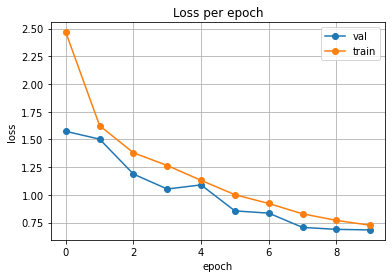

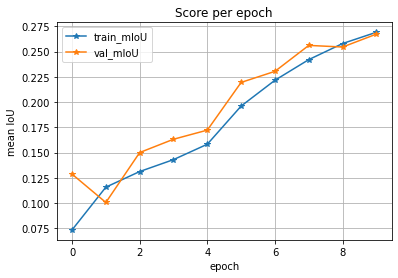

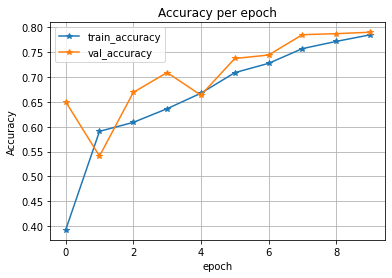

In [ ]:
plot_loss(history)
print()
plot_score(history)
print()
plot_acc(history)

In [ ]:
# #Load the model
# PATH = '/content/MyDrive/DeepLearning/Unet-Mobilenet.pth'
# model = torch.load(PATH)
# model.eval()

<a name="t8"></a>
# Storing, Transforming and Loading Test Dataset

Dataset to transform and load train dataset to mini-batches

In [ ]:
#similar to train dataset
class DroneTestDataset(Dataset):
    
    def __init__(self, img_path, mask_path, X, transform=None):
        self.img_path = img_path
        self.mask_path = mask_path
        self.X = X
        self.transform = transform
      
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        img = cv2.imread(self.img_path + self.X[idx] + '.jpg')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.mask_path + self.X[idx] + '.png', cv2.IMREAD_GRAYSCALE)
        
        if self.transform is not None:
            aug = self.transform(image=img, mask=mask)
            img = Image.fromarray(aug['image'])
            mask = aug['mask']
        
        if self.transform is None:
            img = Image.fromarray(img)
        
        mask = torch.from_numpy(mask).long()
        
        return img, mask


t_test = A.Resize(768, 1152, interpolation=cv2.INTER_NEAREST)
test_set = DroneTestDataset(IMAGE_PATH, MASK_PATH, X_test, transform=t_test)

<a name="t9"></a>

# Test Result Analysis


Mean test accuracy and test IOU calculation 

In [ ]:
#predict output and calculate IOU score over mask and predicted values
def predict_image_mask_miou(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        score = mIoU(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, score

In [ ]:
#predict output and calculate pixel accuracy over mask and predicted values
def predict_image_mask_pixel(model, image, mask, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    model.eval()
    t = T.Compose([T.ToTensor(), T.Normalize(mean, std)])
    image = t(image)
    model.to(device); image=image.to(device)
    mask = mask.to(device)
    with torch.no_grad():
        #unsqueeze adds a dummy dimension at the beginning of the tensor.
        image = image.unsqueeze(0)
        mask = mask.unsqueeze(0)
        
        output = model(image)
        acc = pixel_accuracy(output, mask)
        masked = torch.argmax(output, dim=1)
        masked = masked.cpu().squeeze(0)
    return masked, acc

Calculating mean IOU and pixel accuracy socre over entire test dataset

In [ ]:
#Calculate IOU score for entire test dataset
def miou_score(model, test_set):
    score_iou = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, score = predict_image_mask_miou(model, img, mask)
        score_iou.append(score)
    return score_iou

In [ ]:
mob_miou = miou_score(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
#Calculate pixel accuracy for enitre test dataset
def pixel_acc(model, test_set):
    accuracy = []
    for i in tqdm(range(len(test_set))):
        img, mask = test_set[i]
        pred_mask, acc = predict_image_mask_pixel(model, img, mask)
        accuracy.append(acc)
    return accuracy

In [ ]:
mob_acc = pixel_acc(model, test_set)

  0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
print('Test Set mIoU', np.mean(mob_miou))

Test Set mIoU 0.32407864236447664


In [ ]:
print('Test Set Pixel Accuracy', np.mean(mob_acc))

Test Set Pixel Accuracy 0.8261220296223957


Plotting test, predicted images

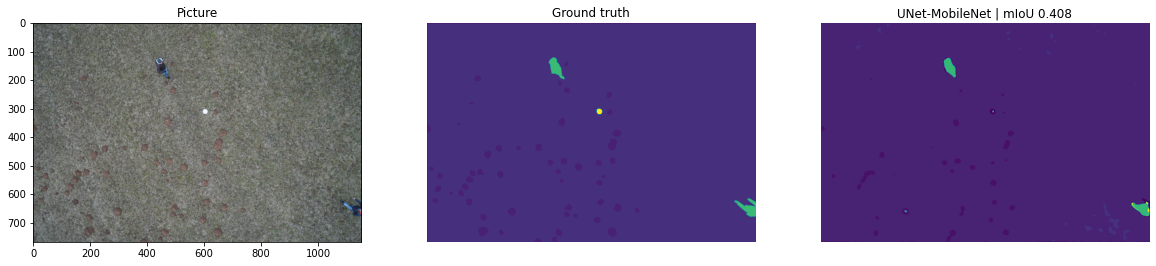

In [ ]:
#plotting image 39
image, mask = test_set[39]
pred_mask, score = predict_image_mask_miou(model, image, mask)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Picture');

ax2.imshow(mask)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score))
ax3.set_axis_off()

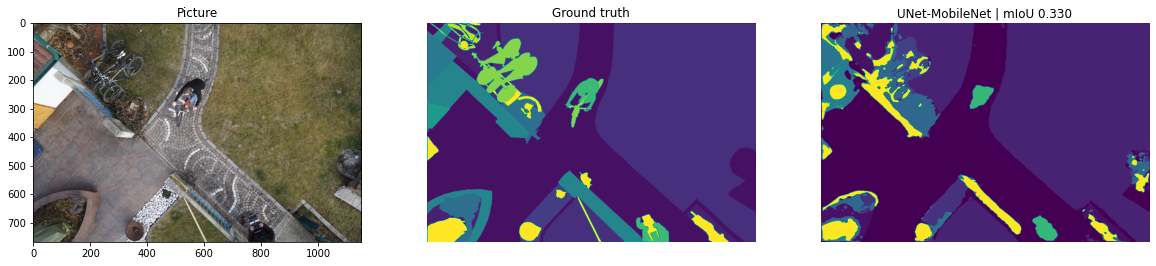

In [ ]:
#plotting image 4
image2, mask2 = test_set[4]
pred_mask2, score2 = predict_image_mask_miou(model, image2, mask2)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image2)
ax1.set_title('Picture');

ax2.imshow(mask2)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask2)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score2))
ax3.set_axis_off()

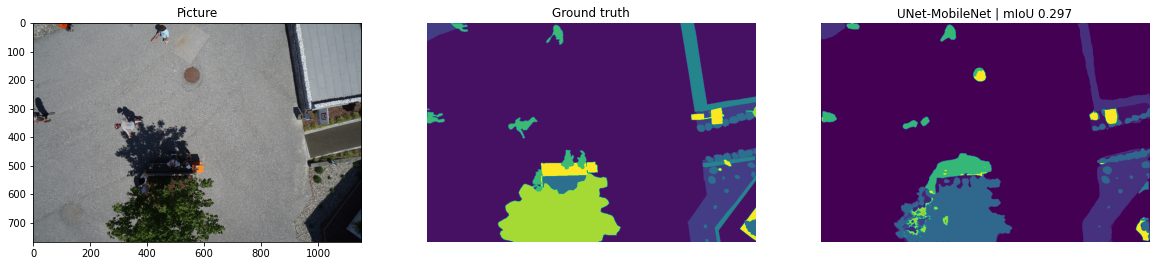

In [ ]:
#plotting image 9
image3, mask3 = test_set[9]
pred_mask3, score3 = predict_image_mask_miou(model, image3, mask3)

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,10))
ax1.imshow(image3)
ax1.set_title('Picture');

ax2.imshow(mask3)
ax2.set_title('Ground truth')
ax2.set_axis_off()

ax3.imshow(pred_mask3)
ax3.set_title('UNet-MobileNet | mIoU {:.3f}'.format(score3))
ax3.set_axis_off()